# Creating a Kaggle Workflow

Here, we will create a **data science workflow**, by exploring a workflow to make competing in the Kaggle Titanic competition easier, using a pipeline of functions to reduce the number of dimensions we need to focus on.

First, we'll read in the `original train.csv` and `test.csv` files from Kaggle.

In [1]:
import pandas as pd

train   = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

holdout.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


Next, using `%load` command, we load an external file of `functions.py`.

In [2]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [3]:
def pre_process(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)

    for col in ["Age_categories","Fare_categories",
                "Title","Cabin_type","Sex"]:
        df = create_dummies(df,col)
    
    return df

train = pre_process(train)
holdout = pre_process(holdout)

The Kaggle workflow we are going to build will combine all of these into a process:

* **Data exploration**, to find patterns in the data
* **Feature engineering**, to create new features from those patterns or through pure experimentation
* **Feature selection**, to select the best subset of our current set of features
* **Model selection/tuning**, training a number of models with different hyperparameters to find the best performer.

We can continue to repeat this cycle as we work to optimize our predictions. At the end of any cycle we wish, we can also use our model to make predictions on the holdout set and then Submit to Kaggle to get a leaderboard score.

While the first two steps of our workflow are relatively freeform, later in this project we'll create some functions that will help automate the complexity of the latter two steps so we can move faster.

Now, let's explore the data!

## Exploring the data

In [4]:
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()
explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
SibSp       891 non-null int64
Parch       891 non-null int64
Survived    891 non-null int64
dtypes: int64(3)
memory usage: 21.0 KB


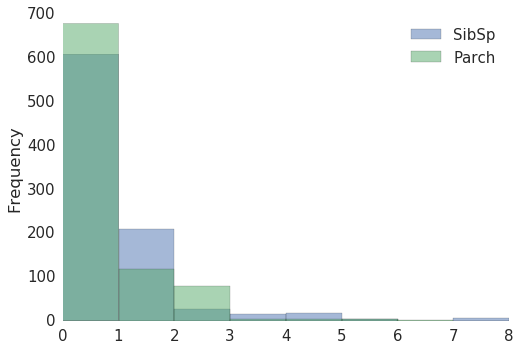

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 5.5})

explore.drop("Survived",axis=1).plot.hist(alpha=0.5,bins=8)
sns.despine(left=True, bottom=True, top=True, right=True)
plt.show()

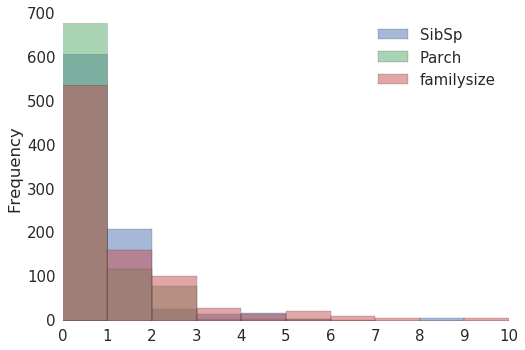

In [6]:
explore["familysize"] = explore[["SibSp","Parch"]].sum(axis=1)
explore.drop("Survived",axis=1).plot.hist(alpha=0.5,bins=10)
plt.xticks(range(11))
sns.despine(left=True, bottom=True, top=True, right=True)
plt.show()

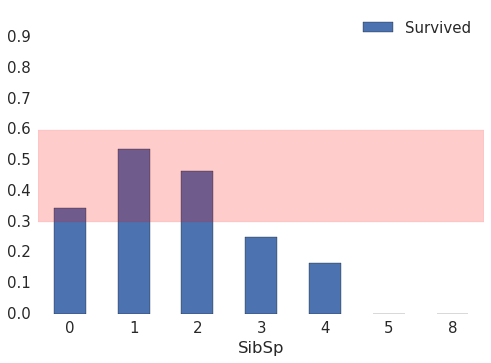

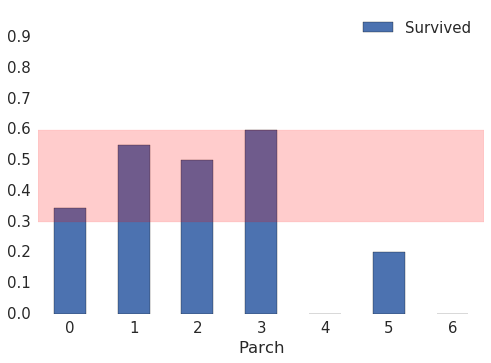

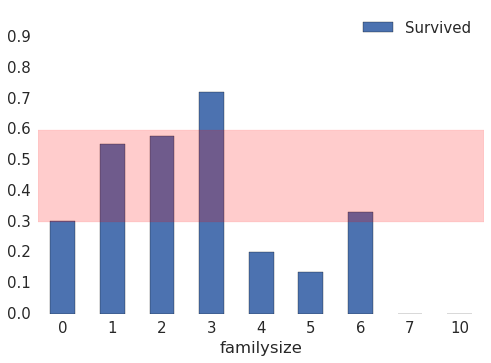

In [7]:
import numpy as np

for col in explore.columns.drop("Survived"):
    pivot = explore.pivot_table(index=col,values="Survived")
    pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
    plt.axhspan(.3, .6, alpha=0.2, color='red')
    sns.despine(left=True, bottom=True, top=True, right=True)
    plt.xticks(rotation=0)
    plt.show()

The SibSp column shows the number of siblings and/or spouses each passenger had on board, while the Parch columns shows the number of parents or children each passenger had onboard. Neither column has any missing values.

The distribution of values in both columns is skewed right, with the majority of values being zero.

You can sum these two columns to explore the total number of family members each passenger had onboard. 
From the last bar chart, only 30% of the passengers who had no family members onboard survived.

The shape of the distribution of values in this case is similar, however there are less values at zero, and the quantity tapers off less rapidly as the values increase.

Looking at the survival rates of the the combined family members, you can see that few of the over 500 passengers with no family members survived, while greater numbers of passengers with family members survived

## Engineering New Features

In [8]:
def process_isalone(df):
    df["familysize"] = df[["SibSp","Parch"]].sum(axis=1)
    df["isalone"] = 0
    df.loc[(df["familysize"] == 0),"isalone"] = 1
    df = df.drop("familysize",axis=1)
    return df

train = process_isalone(train)
holdout = process_isalone(holdout)

The next step in our workflow is feature selection. In the Feature Preparation, Selection and Engineering mission, we used scikit-learn's `feature_selection.RFECV` class to automate selecting the best-performing features using recursive feature elimination.

To speed up our Kaggle workflow, we can create a function that performs this step for us, which will mean we can perform feature selection by calling a self-contained function and focus our efforts on the more creative part - exploring the data and engineering new features.

Let's write a function that:

* Accepts a dataframe as input
* Performs data preparation for machine learning
* Uses recursive feature elimination and the random forests algorithm to find the best-performing set of features

## Selecting the Best-Performing Features

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

def select_features(df):
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(['PassengerId','Survived'], axis=1)
    all_y = df['Survived']
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf, cv=10)
    selector.fit(all_X, all_y)
    best_columns = list(all_X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    return best_columns

cols = select_features(train)

Best Columns 
------------
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Young Adult', 'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']



/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


## Selecting and Tuning Different Algorithms

Just like we did with feature selection, we can write a function to do the heavy lifting of model selection and tuning. The function we'll create will use three different algorithms and use grid search to train using different combinations of hyperparameters to find the best performing model.

We can achieve this by creating a list of dictionaries— that is, a list where each element of the list is a dictionary. Each dictionary should contain:

* The name of the particular model
* An estimator object for the model
* A dictionary of hyperparameters that we'll use for grid search.

Here's an example of what one of these dictionaries will look like:

```python
{
    "name": "KNeighborsClassifier",
    "estimator": KNeighborsClassifier(),
    "hyperparameters":
        {
            "n_neighbors": range(1,20,2),
            "weights": ["distance", "uniform"],
            "algorithm": ["ball_tree", "kd_tree", "brute"],
            "p": [1,2]
        }
}
```

We can then use a for loop to iterate over the list of dictionaries, and for each one we can use scikit-learn's `model_selection.GridSearchCV` class to find the best set of performing parameters, and add values for both the parameter set and the score to the dictionary.

Finally, we can return the list of dictionaries, which will have our trained `GridSearchCV` objects as well as the results so we can see which was the most accurate.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

def select_model(df:pd.DataFrame, features: list):
    all_X = df[features]
    all_y = df['Survived']
    # We list each models in a list of dict
    models = [{
            'name': 'LogisticRegression',
            'estimator': LogisticRegression(),
            'hyperparameters': {
                'solver': ["newton-cg", "lbfgs", "liblinear"]
            }
        },{
            'name': 'KNeighborsClassifier',
            'estimator': KNeighborsClassifier(),
            'hyperparameters': {
                'n_neighbors': range(1,20,2),
                'weights': ['distance', 'uniform'],
                'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                'p': [1,2]
            }
        },{
            'name': 'RandomForestClassifier',
            'estimator': RandomForestClassifier(random_state=1),
            'hyperparameters': {
                'n_estimators': [4, 6, 9],
                'criterion': ['entropy', 'gini'],
                'max_depth': [2, 5, 10],
                'max_features': ['log2', 'sqrt'],
                'min_samples_leaf': [1, 5, 8],
                'min_samples_split': [2, 3, 5]
            }
        }]
    
    for model in models:
        print(model['name'])
        print('-'*len(model['name']))
        grid = GridSearchCV(model['estimator'],
                            param_grid=model['hyperparameters'],
                            cv=10)
        grid.fit(all_X, all_y)
        model['best_params'] = grid.best_params_
        model['best_model'] = grid.best_estimator_
        model['best_score'] = grid.best_score_
        
        print('Best score: {}'.format(model['best_score']))
        print('Best Params: {}\n'.format(model['best_params']))
        
    return models

result = select_model(train, cols)

LogisticRegression
------------------
Best score: 0.8204264870931538
Best Params: {'solver': 'liblinear'}

KNeighborsClassifier
--------------------
Best score: 0.7755331088664422
Best Params: {'weights': 'uniform', 'algorithm': 'brute', 'n_neighbors': 5, 'p': 1}

RandomForestClassifier
----------------------
Best score: 0.8294051627384961
Best Params: {'min_samples_split': 5, 'n_estimators': 4, 'max_depth': 5, 'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 1}



## Making a Submission to Kaggle

After running our function, we will have three scores from three different models. At this point in the workflow, we have a decision to make: Do we want to train our best model on the holdout set and make a Kaggle submission, or do we want to go back to engineering features.

We may find that adding a feature to our model doesn't improve your accuracy. In that case we should go back to data exploration and repeat the cycle again.

If we're going to be continually submitting to Kaggle, a function will help make this easier. Let's create a function to automate this.

In [11]:
def save_submission_file(model, cols, filename='submission.csv'):
    holdout_data = holdout[cols]
    predictions = model.predict(holdout_data)
    
    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids,
                 "Survived": predictions}
    submission = pd.DataFrame(submission_df)

    submission.to_csv(filename,index=False)

best_rf_model = result[2]["best_model"]
save_submission_file(best_rf_model,cols)

# Conclusion

In this project, we have created a reproducible workflow to help us iterate over ideas and continue to improve the accuracy of our predictions. We also created helper functions which will make feature selection, model selection/tuning and creating submissions much easier as we continue to explore the data and create new features.